# COMPSCI713 Group 7 Code Implementation

The code has undergone multiple revisions as the report was compiled, and is currently set up to play with two CFR bots against themselves. Further experiments and changes were attempted but we ran out of time to implement them and may have compromised the algorithm.

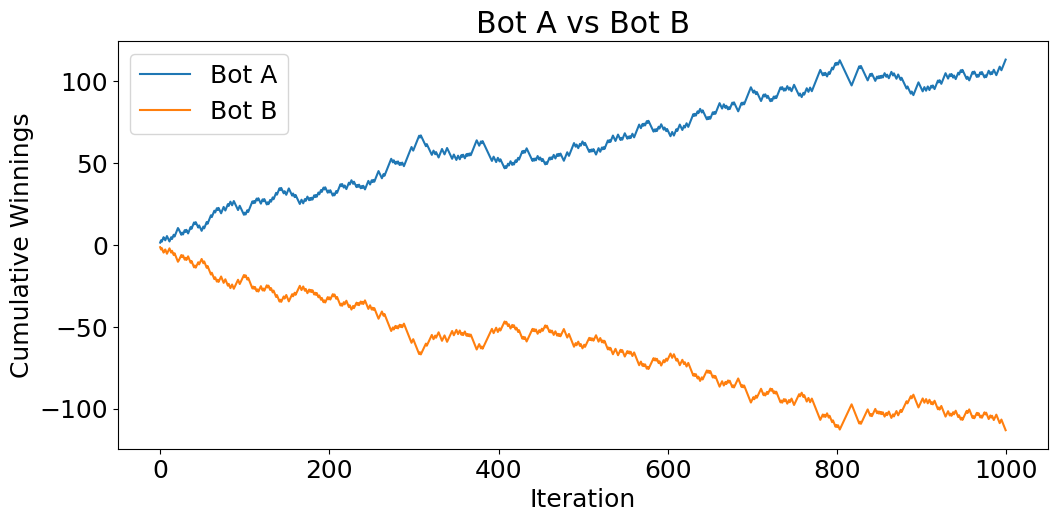

Average Payoff for Bot A: 0.11
Average Payoff for Bot B: -0.11
Total Winnings for Bot A: 113.20
Total Winnings for Bot B: -113.20


In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define hyperparameters and configurations
num_cards = 3  # Number of cards in the deck
iterations = 1000  # Number of iterations for the bots to play against each other

# Hyperparameters for Bot A
discount_factor_A = 0.4
exploration_rate_A = 0.60

# Hyperparameters for Bot B
discount_factor_B = 0.9
exploration_rate_B = 0.55

# Define utility functions
def get_payoff(card_1, card_2, action_1, action_2):
    if action_1 == 'fold':
        return -1
    elif action_2 == 'fold':
        return 1
    else:
        return 2 * (1 if card_1 > card_2 else -1)

# Define the CFR Bot class
class CFRBot:
    def __init__(self, num_cards, discount_factor, exploration_rate):
        self.num_cards = num_cards
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.regret_sum = np.zeros((num_cards, num_cards, 2, 2))  # regrets
        self.strategy_sum = np.zeros((num_cards, num_cards, 2, 2))  # strategy sums
        self.strategy = np.zeros((num_cards, num_cards, 2, 2)) + 0.5  # current strategy

    def get_strategy(self, card_1, card_2, history):
        regret_sum = self.regret_sum[card_1, card_2, history]
        normalizing_sum = np.sum(np.maximum(regret_sum, 0))
        strategy = np.maximum(regret_sum, 0) / (normalizing_sum if normalizing_sum > 0 else 1)
        strategy = (1 - self.exploration_rate) * strategy + self.exploration_rate / 2
        return strategy / np.sum(strategy)  # Ensure probabilities sum to 1

    def get_action(self, card_1, card_2, history):
        strategy = self.get_strategy(card_1, card_2, history)
        return np.random.choice([0, 1], p=strategy)

    def train(self, card_1, card_2, history, p0, p1):
        if history == 2:
            payoff = get_payoff(card_1, card_2, 'bet', 'bet')
            return payoff

        strategy = self.get_strategy(card_1, card_2, history)
        util = np.zeros(2)
        node_util = 0
        for a in range(2):
            next_history = history + 1
            if history == 1 and a == 0:
                payoff = get_payoff(card_1, card_2, 'check', 'fold')
                util[a] = -payoff
            else:
                if history == 1:
                    payoff = get_payoff(card_1, card_2, 'check', 'bet')
                    next_history = 2
                util[a] = -self.train(card_1, card_2, next_history, p0 if history % 2 == 0 else p0 * strategy[a], p1 if history % 2 == 1 else p1 * strategy[a])
            node_util += strategy[a] * util[a]

        for a in range(2):
            regret = util[a] - node_util
            self.regret_sum[card_1, card_2, history, a] *= self.discount_factor  # Apply discount factor
            self.regret_sum[card_1, card_2, history, a] += (p0 if history % 2 == 0 else p1) * regret
            self.strategy_sum[card_1, card_2, history, a] += (p0 if history % 2 == 0 else p1) * strategy[a]

        return node_util

    def get_average_strategy(self):
        avg_strategy = np.zeros_like(self.strategy)
        for i in range(self.num_cards):
            for j in range(self.num_cards):
                for k in range(2):
                    normalizing_sum = np.sum(self.strategy_sum[i, j, k])
                    if normalizing_sum > 0:
                        avg_strategy[i, j, k] = self.strategy_sum[i, j, k] / normalizing_sum
                    else:
                        avg_strategy[i, j, k] = 0.5
        return avg_strategy

# Initialize the bots
bot_A = CFRBot(num_cards, discount_factor_A, exploration_rate_A)
bot_B = CFRBot(num_cards, discount_factor_B, exploration_rate_B)

# Training the bots and recording results
def train_bots(bot_A, bot_B, iterations):
    results_A = np.zeros(iterations)
    results_B = np.zeros(iterations)
    for i in range(iterations):
        cards = np.random.permutation(num_cards)
        card_1, card_2 = cards[:2]
        payoff_A = bot_A.train(card_1, card_2, 0, 1, 1)
        payoff_B = bot_B.train(card_2, card_1, 0, 1, 1)
        results_A[i] = payoff_A
        results_B[i] = -payoff_A  # Payoff_B is the negative of Payoff_A
    return results_A, results_B

results_A, results_B = train_bots(bot_A, bot_B, iterations)
total_winnings_A = np.sum(results_A)
total_winnings_B = np.sum(results_B)

# Displaying the results
plt.rcParams['font.size'] = 18
plt.figure(figsize=(12, 18))
plt.subplot(3, 1, 1)
plt.plot(np.cumsum(results_A), label='Bot A')
plt.plot(np.cumsum(results_B), label='Bot B')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Winnings')
plt.title('Bot A vs Bot B')
plt.legend()
plt.show()

print(f"Average Payoff for Bot A: {np.mean(results_A):.2f}")
print(f"Average Payoff for Bot B: {np.mean(results_B):.2f}")
print(f"Total Winnings for Bot A: {total_winnings_A:.2f}")
print(f"Total Winnings for Bot B: {total_winnings_B:.2f}")